In [1]:
#
import warnings 
warnings.filterwarnings("ignore")

# Forward simulation of a conductive target on a cylindrical mesh

[![License: CC BY 4.0](https://licensebuttons.net/l/by/4.0/80x15.png)](https://creativecommons.org/licenses/by/4.0/)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize, SymLogNorm
import time
import ipywidgets

import discretize
from simpeg.electromagnetics import time_domain as tdem
from simpeg import maps

# solver 
from simpeg.utils.solver_utils import get_default_solver

In [3]:
Solver = get_default_solver()
Solver

pymatsolver.direct.mumps.Mumps

## define survey and model parameters

- specifiy conductivity of background, target, air
- define target geometry

In [4]:
# conductivity values
rho_back = 500

sigma_target = np.r_[1./rho_back, 1, 10, 100, 1e3, 1e4]
sigma_air = 1e-8
sigma_back = 1/rho_back

# target geometry
target_radius = 50
target_thickness = 20
target_z = -250 + target_thickness/2 * np.r_[-1, 1]

print(f"target conductances: {sigma_target * target_thickness}")

target conductances: [4.e-02 2.e+01 2.e+02 2.e+03 2.e+04 2.e+05]


Survey parameters: 
- assume central loop system 
- specify rx times

In [5]:
# transmitter
tx_height = 30
tx_radius = 10

# receiver times
rx_times = 1e-3 * np.logspace(-1, 1, 30)  # 30 time-channels between 0.1ms and 10ms

In [6]:
def diffusion_distance(sigma, t):
    """
    Compute the diffusion distance based on the conductivity and time
    """
    return 1260 * np.sqrt(t/sigma)

In [7]:
# minimum diffusion distance (max conductivity, earliest time) 
diffusion_distance(sigma_target.max(), rx_times.min())

np.float64(0.126)

In [8]:
# maximum diffusion distance (background conductivity, latest time)
diffusion_distance(sigma_back, rx_times.max())

np.float64(2817.4456516497353)

## design a mesh
- using the cylindrically symmetric mesh
- similar to setting up a tensor mesh (define x, z plane and rotate about axis of symmetry)


In [9]:
cell_size_x = 1
cell_size_z = 1
padding_factor = 1.3

n_cells_x = int(target_radius / cell_size_x)
n_cells_z = int((np.max(np.abs(target_z)) + 10) / cell_size_z)
n_cells_above_ground = int(tx_height / cell_size_z)
n_padding_x = 28
n_padding_z = 28

mesh = discretize.CylindricalMesh(
    [
        [(cell_size_x, n_cells_x), (cell_size_x, n_padding_x, padding_factor)], # x-direction 
        [np.pi*2],  # theta-direction
        [(cell_size_z, n_padding_z, -padding_factor), (cell_size_z, n_cells_z+n_cells_above_ground), (cell_size_z, n_padding_z, padding_factor)]  # z-direction
    ], 
    origin = "000"
)
mesh.origin = np.r_[0, 0, -mesh.h[2][:n_padding_z+n_cells_z].sum()]
mesh.n_cells

27768

<Axes: xlabel='x', ylabel='z'>

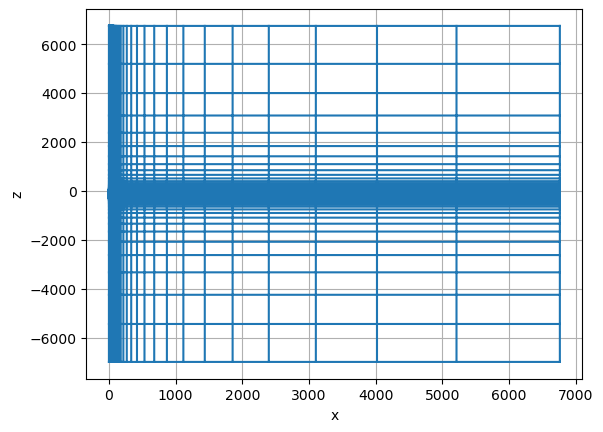

In [10]:
fig, ax = plt.subplots(1, 1)
mesh.plot_grid(ax=ax)

## put model on the mesh
- use a dictionary to store our model vectors 

In [11]:
models = {}
for sig in sigma_target:
    
    key = f"sigma_{sig:1.0e}"
    
    m = sigma_air * np.ones(mesh.n_cells)
    m[mesh.cell_centers[:, 2] < 0] = 1./rho_back
    
    inds_target = (
        (mesh.cell_centers[:, 0] < target_radius) &
        (mesh.cell_centers[:, 2] < target_z.max()) &
        (mesh.cell_centers[:, 2] > target_z.min()) 
    )
    m[inds_target] = sig
    models[key] = m
model_keys = list(models.keys())

In [12]:
model_keys

['sigma_2e-03',
 'sigma_1e+00',
 'sigma_1e+01',
 'sigma_1e+02',
 'sigma_1e+03',
 'sigma_1e+04']

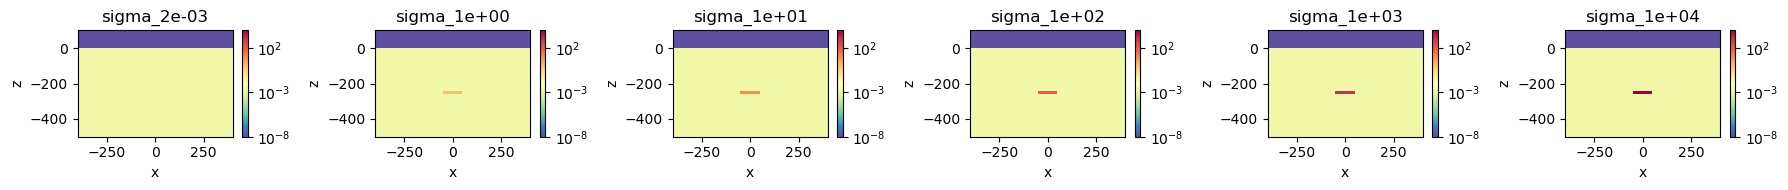

In [13]:
fig, ax = plt.subplots(1, len(models), figsize=(3*len(models), 2))

xlim = 400*np.r_[-1, 1]
zlim = np.r_[-500, 100]

for i, key in enumerate(models.keys()):
    plt.colorbar(mesh.plot_image(
        models[key], ax=ax[i], 
        pcolor_opts={"norm":LogNorm(vmin=sigma_air, vmax=sigma_target.max()), "cmap":"Spectral_r"},
        mirror=True
    )[0], ax=ax[i])
    ax[i].set_xlim(xlim)
    ax[i].set_ylim(zlim)
    ax[i].set_title(key)
    
plt.tight_layout()

## set up the survey

- central loop system, step-off waveform 
- look at $b_z$, $db_z/dt$

In [14]:
waveform=tdem.sources.StepOffWaveform()

rx_dbdt = tdem.receivers.PointMagneticFluxTimeDerivative(
    np.r_[0, 0, tx_height], times=rx_times, orientation="z"
)

rx_b = tdem.receivers.PointMagneticFluxDensity(
    np.r_[0, 0, tx_height], times=rx_times, orientation="z"
)

src = tdem.sources.CircularLoop(
    location=np.r_[0, 0, tx_height], radius=tx_radius, receiver_list=[rx_dbdt, rx_b], waveform=waveform
)

survey = tdem.Survey([src])

## set up the simulation 
- specify the time-steps at which the simulation is evaluated (this needs to be finer than our receiver measurement times) 

In [15]:
nsteps = 20
time_steps = [
    (1e-5, nsteps), (3e-5, nsteps), (1e-4, nsteps), (3e-4, nsteps+10)
]

In [16]:
simulation = tdem.simulation.Simulation3DMagneticFluxDensity(
    mesh=mesh, survey=survey, time_steps=time_steps, solver=Solver,
    sigmaMap=maps.IdentityMap(mesh)
)

(-0.02, 0.015)

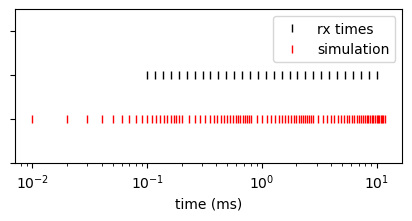

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(5, 2))

ax.semilogx((rx_times)*1e3, np.zeros_like(rx_times), "|k", label="rx times")
ax.semilogx(simulation.times*1e3, -0.01*np.ones_like(simulation.times), "|r", label="simulation")
ax.legend()
ax.set_xlabel("time (ms)")
ax.set_yticklabels("")
ax.set_ylim([-0.02, 0.015])

## solve maxwell's equations 
- `fields` stores the computed fields at every timestep (we will use this for visualization)
- `dpred` stores our predicted data as an object 

In [18]:
fields = {}
dpred = {}

for key, val in models.items():
    t = time.time()
    fields[key] = simulation.fields(val)
    dpred[key] = simulation.make_synthetic_data(val, f=fields[key])
    print(f"done {key}... {time.time() - t: 1.2e}s")

done sigma_2e-03...  2.21e+00s
done sigma_1e+00...  2.14e+00s
done sigma_1e+01...  2.13e+00s
done sigma_1e+02...  2.56e+00s
done sigma_1e+03...  2.43e+00s
done sigma_1e+04...  2.23e+00s


In [19]:
def plot_data(keys_to_plot=list(dpred.keys()), rx_type="dbdt", ax=None, difference=False): 
    """
    A function for plotting the data corresponding to the provided keys_to_plot
    on a log-log plot 
    """
    if ax is None: 
        fig, ax = plt.subplots(1, 1)

    if rx_type == "dbdt":
        rx = rx_dbdt
        ylabel = "db/dt (V/m$^2$)"
    elif rx_type == "b": 
        rx = rx_b
        ylabel = "B (T)"
        
    for i, key in enumerate(keys_to_plot):
        val = dpred[key][src, rx]

        if difference is True: 
            val = val - dpred[model_keys[0]][src, rx]
            if key == model_keys[0]:
                pass
        
        if key == model_keys[0]: 
            color = "--k"
            label="background"
        else:
            color_ind = model_keys.index(key) - 1
            color = f"C{i-1}"
            label = f"{float(key.split('_')[-1]) * target_thickness:1.0f} S"
            
        ax.loglog(rx_times*1e3, np.abs(val), color, label=label)
    ax.legend()
    ax.set_xlabel("time (ms)")
    ax.set_ylabel(ylabel)
    ax.grid(alpha=0.7)
    return ax

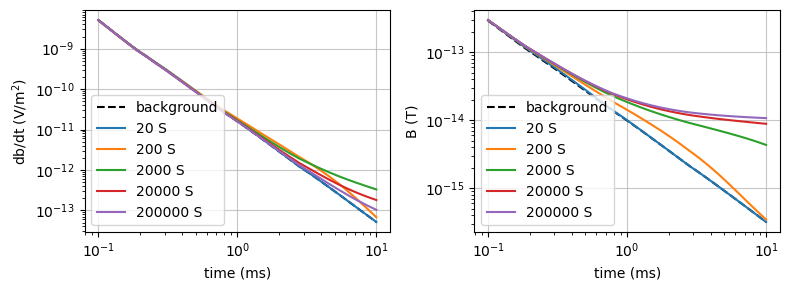

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

plot_data(rx_type="dbdt", ax=ax[0])
plot_data(rx_type="b", ax=ax[1])
plt.tight_layout()

## plot the fields

In [21]:
def plot_current_density(
    key, time_ind, ax=None, xlim = 400*np.r_[-1, 1], zlim=np.r_[-500, 80],
    colorbar=False, ylabels=True, vmax=None
):
    """
    A function for plotting the current density on a cyl mesh. This assumes the "fields" 
    are defined earlier as a dictionary and you are interested in plotting the current 
    density due to the model corresponding with the provided "key" at time ti. 
    """
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    jplt = mesh.average_edge_y_to_cell * fields[key][:, "j", time_ind]
    
    if vmax is not None: 
        pcolor_opts={"norm":Normalize(vmin=-vmax, vmax=vmax), "cmap":"coolwarm"}
    else: 
        pcolor_opts = {"cmap":"coolwarm"}
    out = mesh.plot_image(
        jplt, ax=ax, 
        mirror=True, mirror_data = -jplt,
        pcolor_opts=pcolor_opts
    )
    
    ax.plot(np.r_[0], tx_height, "ko", ms=2)
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)
    ax.set_aspect(1)
    
    if colorbar is True: 
        cb = plt.colorbar(out[0], ax=ax, orientation="horizontal")
        cb.set_label("current density")
    
    if ylabels is False: 
        ax.set_ylabel("")
        ax.set_yticklabels("")

    return ax

In [22]:
def plot_dbdt(
    key, time_ind, field_type="dbdt", ax=None, xlim=400*np.r_[-1, 1], zlim=np.r_[-500, 80],
    colorbar=False, ylabels=True, vmax=None, vmin=None
):
    """
    A function for plotting the db/dt or b on a cyl mesh. This assumes the "fields" 
    are defined earlier as a dictionary and you are interested in plotting the current 
    density due to the model corresponding with the provided "key" at time index (time_ind). 
    """
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    field_to_plot = fields[key][:, field_type, :]

    if vmax is None: 
        vmax = 1e-3 * np.max(np.abs(field_to_plot))
    if vmin is None: 
        if field_type == "dbdt":
            vmin = 1e-9 * vmax
        else: 
            vmin = 1e-6 * vmax
    
    dbdtplt = mesh.average_face_to_cell_vector * field_to_plot[:, time_ind]
    out = mesh.plot_image(
        dbdtplt, "CCv", view="vec", ax=ax, 
        mirror=True,
        pcolor_opts={"norm":LogNorm(vmin=vmin, vmax=vmax)},
        range_x=xlim, 
        range_y=zlim,
        stream_threshold=vmin
    )
    ax.plot(np.r_[0], tx_height, "ko", ms=2)
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)
    ax.set_aspect(1)
    if ylabels is False: 
        ax.set_ylabel("")
        ax.set_yticklabels("")
    if colorbar is True: 
        cb = plt.colorbar(out[0], ax=ax, orientation="horizontal")
        cb.set_label("db/dt (V/m$^2$)" if field_type=="dbdt" else "B (T)")
    return ax

In [23]:
def plot_fields_and_data(key, time_ind, field_type="dbdt", xlim=400*np.r_[-1, 1], zlim=np.r_[-450, 50]):
    """
    Function to plot the current density, magnetic field (db/dt or b) and data for a given model
    (specified by the key) and a specific time index (time_ind). 
    """
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    t = simulation.times[time_ind]-waveform.off_time
    if t*1e3 > 0.99: 
        time_label = f"{t*1e3:1.1f} ms"
    else: 
        time_label = f"{t*1e3:1.2f} ms"
        
    fig.suptitle(f"{float(key.split('_')[-1]) * target_thickness:1.0f} S target, t={time_label}")
                 
    plot_current_density(key, time_ind, ax=ax[0], colorbar=True, xlim=xlim, zlim=zlim)
    plot_dbdt(key, time_ind, field_type=field_type, ax=ax[1], colorbar=True, xlim=xlim, zlim=zlim)
    plot_data([model_keys[0], key], rx_type=field_type, ax=ax[2])
    if simulation.times[time_ind] > rx_times[0]: 
        ylim = ax[2].get_ylim()
        ax[2].plot(1e3*simulation.times[time_ind]*np.r_[1, 1], ylim, ":k")
        ax[2].set_ylim(ylim)
    plt.tight_layout()
    

In [24]:
ipywidgets.interact(
    plot_fields_and_data, 
    key = model_keys, 
    field_type = ipywidgets.ToggleButtons(options=["dbdt", "b"], value="b"),
    time_ind = ipywidgets.IntSlider(min=0, max=len(simulation.times)-1, value=0),
    xlim=ipywidgets.fixed(400*np.r_[-1, 1]),
    zlim=ipywidgets.fixed([-450, 50])
)

interactive(children=(Dropdown(description='key', options=('sigma_2e-03', 'sigma_1e+00', 'sigma_1e+01', 'sigma…

<function __main__.plot_fields_and_data(key, time_ind, field_type='dbdt', xlim=array([-400,  400]), zlim=array([-450,   50]))>